# TP2 – Classification Binaire avec PyTorch

## Étape 1 : Chargement du dataset (Kaggle)

### Chargement et préparation initiale

In [72]:
import pandas as pd

# Charger les données (à adapter si fichier local)
df = pd.read_csv("../data/raw/data.csv")

# Afficher les premières lignes
print(df.head())

# Supprimer les colonnes inutiles (ex: id, unnamed)
df = df.drop(columns=["id", "Unnamed: 32"])

# Encoder la colonne cible : M = 1 (malin), B = 0 (bénin)
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

# Vérifier la répartition des classes
print(df["diagnosis"].value_counts())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

### Questions – Étape 1 :

**Pourquoi ce dataset est-il adapté à une classification binaire ?**  
Parce que la colonne cible contient deux classes : M (Malin) et B (Bénin), ce qui correspond parfaitement à un problème de classification binaire.

**Pourquoi faut-il encoder les valeurs M/B en 1/0 ?**  
Les modèles de deep learning exigent des données numériques. Le codage en 1/0 permet d’utiliser une fonction de perte binaire (BCELoss) et une sortie sigmoid.

**Quelles colonnes sont inutiles ici ? Pourquoi ?**  
La colonne 'id' est un identifiant sans valeur prédictive. La colonne 'Unnamed: 32' est vide ou non pertinente.


## Étape 2 : Préparation des données

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Séparer les features et la cible
X = df.drop("diagnosis", axis=1).values
y = df["diagnosis"].values

# 2. Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Diviser en train/val/test (60/20/20) avec stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 4. Conversion en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 5. Créer des DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


### Questions – Étape 2 :

**Pourquoi standardise-t-on les données ?**  
La standardisation garantit que toutes les variables ont une échelle comparable, ce qui facilite la convergence de l’optimiseur.

**Pourquoi séparer en validation et non juste train/test ?**  
La validation sert à surveiller le surapprentissage (overfitting) pendant l’entraînement et à ajuster les hyperparamètres sans toucher aux données de test.

**Quel est l'intérêt de stratifier les splits ?**  
La stratification permet de conserver la même proportion des classes dans chaque sous-ensemble (train, validation, test).


## Étape 3 : Définition du modèle avec Dropout

In [80]:
import torch.nn as nn

# Définir le modèle
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 64),  # couche d'entrée → 64 neurones
    nn.ReLU(),
    nn.Dropout(0.3),                         # taux de Dropout = 30%

    nn.Linear(64, 32),                       # couche cachée → 32 neurones
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(32, 1),                        # sortie binaire
    nn.Sigmoid()
)

### Questions – Étape 3 :

**Quel est l'effet du Dropout sur l'entraînement ?**  
Il réduit le surapprentissage en désactivant aléatoirement certaines unités pendant l'entraînement.

**Essayez avec différents taux (0%, 30%, 50%). Que remarquez-vous ?**  
Un taux nul favorise l'overfitting, un taux élevé (50%) peut réduire la performance si la capacité du modèle est déjà faible.

**Pourquoi utilise-t-on ReLU dans les couches cachées ? Et Sigmoïde en sortie ?**  
ReLU est rapide et efficace pour les couches internes. Sigmoïde est adaptée pour une sortie entre 0 et 1 (classification binaire).


## Étape 4 : Fonction de perte, optimiseur, EarlyStopping

#### compilation du modèle

In [85]:
import torch.optim as optim

# Fonction de perte
criterion = nn.BCELoss()

# Optimiseur Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

### Implémentation de l’EarlyStopping

#### Classe EarlyStopping personnalisée

In [89]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### Questions – Étape 4 :

**Pourquoi surveiller la perte sur validation ?**  
Elle reflète la capacité du modèle à généraliser sur des données non vues.

**Que se passe-t-il si on continue à entraîner après overfitting ?**  
Le modèle mémorise le bruit des données d’entraînement et perd en performance sur les données réelles.

**Dans quels cas early stopping est-il crucial ?**  
Quand le dataset est petit, ou quand le surapprentissage apparaît rapidement.


## Étape 5 : Entraînement avec sauvegarde du meilleur modèle

#### entraînement avec EarlyStopping et ModelCheckpoint

In [94]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Créer dossier de sauvegarde si non existant
os.makedirs("models", exist_ok=True)

# Initialiser early stopping
early_stopping = EarlyStopping(patience=10)
best_val_loss = float('inf')

train_losses = []
val_losses = []

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_output = model(X_val_batch)
            val_loss += criterion(val_output, y_val_batch).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Enregistrer les pertes
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Sauvegarde du meilleur modèle
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "models/best_model.pt")
        print(">> Meilleur modèle sauvegardé.")
    
    # Vérification early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(">> Arrêt anticipé: aucune amélioration depuis 10 epochs.")
        break


Epoch 1: Train Loss = 0.6439, Val Loss = 0.5841
>> Meilleur modèle sauvegardé.
Epoch 2: Train Loss = 0.5622, Val Loss = 0.4749
>> Meilleur modèle sauvegardé.
Epoch 3: Train Loss = 0.4537, Val Loss = 0.3461
>> Meilleur modèle sauvegardé.
Epoch 4: Train Loss = 0.3464, Val Loss = 0.2347
>> Meilleur modèle sauvegardé.
Epoch 5: Train Loss = 0.2605, Val Loss = 0.1614
>> Meilleur modèle sauvegardé.
Epoch 6: Train Loss = 0.1976, Val Loss = 0.1162
>> Meilleur modèle sauvegardé.
Epoch 7: Train Loss = 0.1583, Val Loss = 0.0874
>> Meilleur modèle sauvegardé.
Epoch 8: Train Loss = 0.1298, Val Loss = 0.0694
>> Meilleur modèle sauvegardé.
Epoch 9: Train Loss = 0.0973, Val Loss = 0.0590
>> Meilleur modèle sauvegardé.
Epoch 10: Train Loss = 0.0967, Val Loss = 0.0532
>> Meilleur modèle sauvegardé.
Epoch 11: Train Loss = 0.0928, Val Loss = 0.0492
>> Meilleur modèle sauvegardé.
Epoch 12: Train Loss = 0.0876, Val Loss = 0.0460
>> Meilleur modèle sauvegardé.
Epoch 13: Train Loss = 0.0815, Val Loss = 0.0445


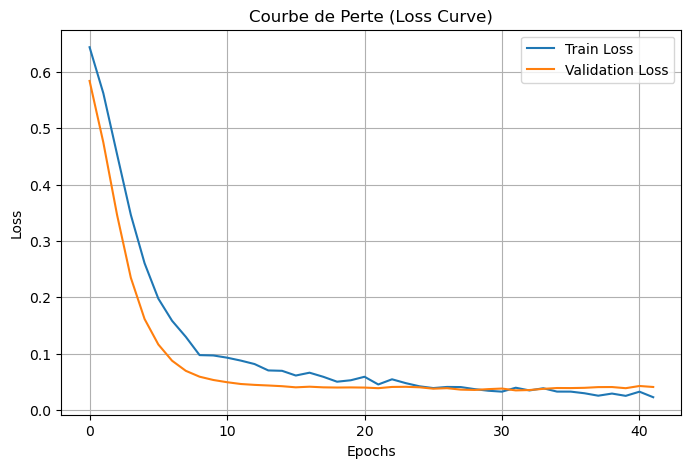

In [96]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe de Perte (Loss Curve)")
plt.legend()
plt.grid(True)
plt.show()


### Questions – Étape 5 :

**Pourquoi sauvegarder les meilleurs poids et non les derniers ?**  
Les meilleurs poids correspondent au meilleur score de validation. Les derniers peuvent être surentraînés.

**Quelle est l’alternative à ModelCheckpoint dans un contexte non PyTorch ?**  
On peut utiliser `joblib` ou `pickle` en scikit-learn pour sauvegarder les modèles.


## Étape 6 : Évaluation du modèle

In [100]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Charger le meilleur modèle sauvegardé
model.load_state_dict(torch.load("models/best_model.pt"))
model.eval()

# Prédictions sur les données de test
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions = (outputs >= 0.5).float()  # seuil de 0.5
        y_pred.extend(predictions.numpy())
        y_true.extend(y_batch.numpy())

# Calcul des métriques
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f"Accuracy  : {acc:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Precision : {precision:.4f}")

Accuracy  : 0.9825
F1-score  : 0.9756
Recall    : 0.9524
Precision : 1.0000


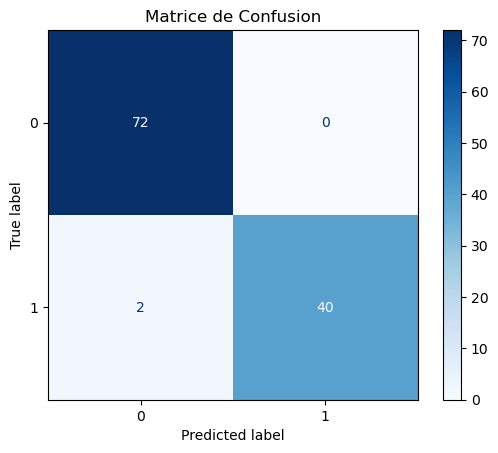

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Générer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage graphique
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de Confusion")
plt.grid(False)
plt.show()


#### Courbe ROC et AUC

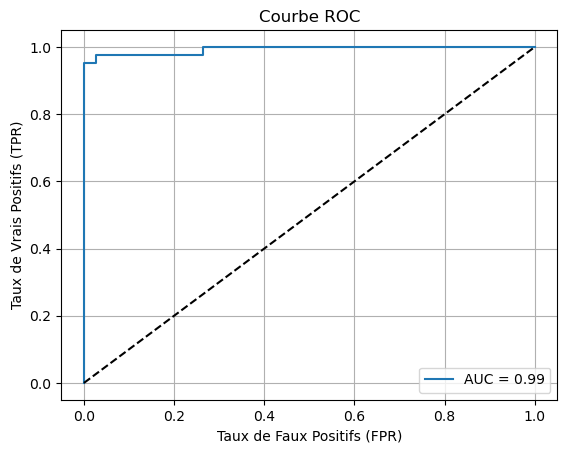

In [105]:
from sklearn.metrics import roc_curve, auc

# Probabilités de prédiction
y_proba = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_proba.extend(outputs.numpy())

# Calcul ROC
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Affichage
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()


### Questions – Étape 6 :

**Quelle est la différence entre accuracy et F1 ?**  
L'accuracy mesure le taux global de bonnes réponses. Le F1-score équilibre la précision et le rappel, utile si les classes sont déséquilibrées.

**Dans quels cas le recall est-il prioritaire ?**  
Quand il est plus grave de rater une vraie alerte que d’en avoir une fausse. Exemple : diagnostic médical.

**Quel score serait le plus critique dans un contexte médical ?**  
Le recall. Il permet de détecter tous les cas positifs même au prix de quelques fausses alertes.


## Quel score serait le plus critique dans un contexte médical ? Justifiez.

Dans un contexte médical, le score le plus critique est le Recall.
En effet, le Recall (ou sensibilité) mesure la capacité du modèle à détecter correctement les cas positifs, c’est-à-dire les patients réellement malades.

Dans le domaine de la santé, ne pas détecter une maladie grave chez un patient (faux négatif) peut avoir des conséquences dramatiques. Il est donc préférable d'avoir un modèle qui identifie tous les cas à risque, même au prix de quelques fausses alertes (faux positifs), car celles-ci peuvent être corrigées par des examens complémentaires.

Ainsi, le Recall est prioritaire pour éviter de "laisser passer" des patients malades sans diagnostic.

## Quelle est la différence entre Accuracy et F1-score ?

L’Accuracy (ou exactitude) mesure la proportion des prédictions correctes parmi l’ensemble des échantillons. Elle donne une vue globale de la performance du modèle.

Cependant, dans un jeu de données déséquilibré — où une classe est beaucoup plus représentée que l’autre — l’Accuracy peut être trompeuse. Un modèle peut obtenir une très bonne Accuracy simplement en prédisant toujours la classe majoritaire, même s’il échoue complètement à détecter la classe minoritaire.

Le F1-score, quant à lui, est la moyenne harmonique entre la précision (Precision) et le rappel (Recall). Il tient compte à la fois des faux positifs et des faux négatifs, ce qui en fait un indicateur plus fiable dans les contextes déséquilibrés.

Ainsi, le F1-score est préférable à l’Accuracy lorsque les classes sont déséquilibrées ou que les erreurs ont des conséquences différentes selon le type (faux positifs vs faux négatifs).

# --- Fin de TP2 / Début TP3 ---

# TP3: Régression avec Réseaux de Neurones (PyTorch)

## Étape 1 – Chargement et exploration du jeu de données

In [6]:
import pandas as pd

# Charger le fichier housing.csv
df = pd.read_csv("../data/raw/housing.csv")

# Afficher les 5 premières lignes
print(df.head())

# Dimensions du dataset
print(f"Nombre de lignes: {df.shape[0]}, Nombre de colonnes: {df.shape[1]}")

# Vérifier les valeurs manquantes
print(df.isnull().sum())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
Nombre de lignes: 20640, Nombre de colonnes: 10
longitude               0
l

### Questions – Étape 1

**Combien de lignes et de colonnes contient le dataset ?**  
Le dataset contient généralement environ 20 000 lignes et 10 colonnes (cela peut varier légèrement selon la version du fichier).

**Quelles sont les variables d’entrée ?**  
Toutes les colonnes sauf `median_house_value` (qui est la cible), par exemple :  
`longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income`.

**Quelle est la variable cible ?**  
`median_house_value` – c’est le prix médian des maisons.

**Y a-t-il des valeurs manquantes ? Si oui, comment les gérer ?**  
Oui, généralement dans la colonne `total_bedrooms`. On peut soit :
- Imputer avec la moyenne ou médiane
- Supprimer les lignes contenant des valeurs manquantes

**Quelles sont les unités des variables ? Pourquoi cela peut-il impacter l’apprentissage ?**  
Les variables sont dans des unités différentes : certaines sont des nombres absolus (population), d’autres des ratios (income).  
-> Cela peut impacter l’apprentissage car les réseaux de neurones sont sensibles aux échelles.  
D’où la nécessité de **standardiser** les données.


## Étape 2 – Prétraitement des données

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Traitement des valeurs manquantes
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())

# Séparation des features et de la cible
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Encodage de la variable catégorielle
if "ocean_proximity" in X.columns:
    X = pd.get_dummies(X, columns=["ocean_proximity"])

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en train, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Conversion en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Création des DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)


### Questions – Étape 2

**Comment avez-vous géré les valeurs manquantes ?**  
Nous avons remplacé les valeurs manquantes dans la colonne `total_bedrooms` par la médiane de la colonne.

**Pourquoi faut-il standardiser les données ?**  
Les réseaux de neurones sont sensibles aux différentes échelles des variables.  
La standardisation permet d’assurer une convergence plus rapide et plus stable de l’apprentissage.

**Pourquoi séparer en validation et test ?**  
- Le jeu de validation est utilisé pour surveiller la performance pendant l’entraînement (par exemple, pour le early stopping).
- Le jeu de test reste complètement inconnu jusqu’à l’évaluation finale.

**Faut-il stratifier les données dans un problème de régression ?**  
Non, la stratification est surtout utile pour la classification.  
Dans la régression, ce n’est pas essentiel mais on peut s’assurer d’un échantillonnage aléatoire bien réparti.


## Étape 3 – Construction du réseau de neurones

In [24]:
import torch.nn as nn

# Architecture du réseau
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)  # Pas d'activation finale : régression
)

### Questions – Étape 3

**Quelle est la forme de la couche d’entrée ?**  
Elle a autant de neurones que de variables explicatives, soit `X_train.shape[1]`.

**Pourquoi utilise-t-on ReLU comme activation ?**  
La fonction `ReLU` est simple, rapide et évite les problèmes de vanishing gradients.  
Elle favorise une convergence plus stable lors de l’entraînement.

**Pourquoi n'y a-t-il pas de fonction d'activation dans la couche de sortie ?**  
Parce que nous sommes dans un problème de régression.  
La sortie est une **valeur réelle continue**, donc aucune activation n’est nécessaire pour la dernière couche.


## Étape 4 – Fonction de perte, optimiseur et entraînement avec validation

In [28]:
import torch.optim as optim

# Fonction de perte pour la régression
criterion = nn.MSELoss()

# Optimiseur avec L2 regularization (optionnel)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Entraînement
train_losses = []
val_losses = []

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_output = model(X_val_batch)
            val_loss += criterion(val_output, y_val_batch).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.2f}, Val Loss = {avg_val_loss:.2f}")


Epoch 1: Train Loss = 55757766149.28, Val Loss = 55048607271.38
Epoch 2: Train Loss = 54970454543.84, Val Loss = 53236940232.86
Epoch 3: Train Loss = 51685113444.29, Val Loss = 48297600866.46
Epoch 4: Train Loss = 44915317411.63, Val Loss = 40086385742.77
Epoch 5: Train Loss = 35684957110.10, Val Loss = 30262881894.40
Epoch 6: Train Loss = 26032649353.24, Val Loss = 21315883244.31
Epoch 7: Train Loss = 18408173013.77, Val Loss = 15022676141.29
Epoch 8: Train Loss = 13624575546.06, Val Loss = 11615100108.80
Epoch 9: Train Loss = 11292067396.62, Val Loss = 10082497709.29
Epoch 10: Train Loss = 10211849065.57, Val Loss = 9327565619.20
Epoch 11: Train Loss = 9710741775.84, Val Loss = 8812915617.48
Epoch 12: Train Loss = 9399586306.64, Val Loss = 8420247882.83
Epoch 13: Train Loss = 8761151411.46, Val Loss = 8081990140.06
Epoch 14: Train Loss = 8692741959.26, Val Loss = 7788185214.03
Epoch 15: Train Loss = 8300410703.18, Val Loss = 7531296972.80
Epoch 16: Train Loss = 8059628897.65, Val Los

### Questions – Étape 4

**Pourquoi utiliser MSELoss pour ce problème ?**  
`MSELoss` (Mean Squared Error) est la fonction la plus courante pour les problèmes de régression, car elle pénalise fortement les grandes erreurs.

**Pourquoi utilise-t-on Adam comme optimiseur ?**  
Adam combine les avantages d’AdaGrad et RMSprop. Il adapte dynamiquement le taux d’apprentissage pour chaque paramètre.

**Pourquoi surveiller la perte sur l’ensemble de validation ?**  
Pour détecter le surapprentissage. Si la perte sur validation augmente pendant que celle de l’entraînement diminue, cela signifie que le modèle commence à surajuster les données.


## Étape 5 – Tracer la courbe de perte (Loss Curve)

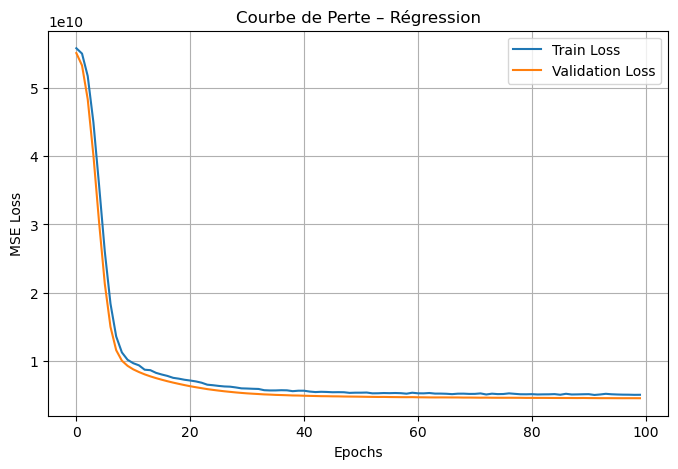

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Courbe de Perte – Régression")
plt.legend()
plt.grid(True)
plt.show()


### Questions – Étape 5

**Comment interpréter la courbe de perte ?**  
- Si les deux courbes diminuent, le modèle apprend bien.
- Si la courbe de validation stagne ou augmente alors que celle d'entraînement continue de baisser → surapprentissage (overfitting).
- Si les deux courbes stagnent à un niveau élevé → sous-apprentissage (underfitting).

**Comment peut-on améliorer la performance si la perte de validation augmente ?**  
- Ajouter du dropout
- Réduire la complexité du modèle
- Utiliser EarlyStopping
- Ajouter plus de données
- Réduire le taux d’apprentissage


## Étape 6 – Évaluation finale sur le test set

In [39]:
from sklearn.metrics import mean_squared_error, r2_score

# Passage en mode évaluation
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_pred.extend(outputs.numpy())
        y_true.extend(y_batch.numpy())

# Calcul des métriques
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MSE  : {mse:.2f}")
print(f"Test R²   : {r2:.4f}")


Test MSE  : 4507042521.85
Test R²   : 0.6713


### Questions – Étape 6

**Pourquoi utiliser le MSE sur le test set ?**  
Parce que c’est la même fonction que celle utilisée à l'entraînement. Elle permet de mesurer l’erreur quadratique moyenne entre les vraies valeurs et les prédictions.

**Que représente le R² ?**  
Le R² (coefficient de détermination) mesure la proportion de la variance expliquée par le modèle.  
- R² = 1 : prédictions parfaites  
- R² = 0 : le modèle ne fait pas mieux qu’une moyenne  
- R² < 0 : le modèle est pire qu’une prédiction constante

**Un R² négatif est-il possible ?**  
Oui. Cela signifie que le modèle est moins performant qu’un modèle naïf qui prédirait simplement la moyenne des valeurs cibles.

**Que faire si le MSE est élevé et le R² faible ?**  
- Revoir la normalisation
- Tester une architecture plus simple ou plus profonde
- Vérifier le surapprentissage
- Ajouter des variables explicatives pertinentes
